# Generating Synthetic Data with Python

Hand's on workshop covering synthetic data with Python.

**Agenda**:
- Overview
- Bootstrapping
- SMOTE
- Image Augmentation
- Synthetic Data Vault (SDV)

## Overview

### What is synthetic data?

Data that is not "real", but has been generated to reflect some real world data or process. 

Data access can be challenging:
- Limited resources
- Privacy concerns

Synthetic data is becoming a prominent strategy to improve data access against both of these cases.


### How do we create synthetic data?

Two primary methods:
1. Simulate real data
2. Use existing model or background knowledge

![Generation Process](images/Synthetic-data-generation.png)


### Key Ideas

- **Utility**: how accurately synthetic data reflects real data or process
    - Depends on use case
- **Anonymization**: ensure protection of sensitive information
- **Reproducibiliy**: generation process can be replicated

In [1]:
# Import Basic Packages (some others will be imported later)
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Classification models/metrics
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

# Functions from .py file
from src.funcs import plot_hist, plot_churn, model_churn, plot_grid

## Bootstrap

Monte Carlo Simulation approach to estimate the uncertainty of a statistic or estimator. Any sample taken from a population includes an inherent error from the randomness of the sampling process itself. We use the Bootstrap method to infer how other samples taken from the same population would have differed due to random error, and thus produce some idea of the uncertainty in our original sample. 

At a high level the process is as follows:
1. Take random sample from a population
1. Consider the sample to be the population
1. Repeatedly sample *with replacement* from original sample to create *bootstrap samples*


In this sense, we can consider each bootstrap sample to be a synthetic set of data points which represent what the original sample *could* have been. We can achieve similar results to the Central Limit Theorem, only using a single sample!

Let's look at an example with a dataset below. We will read pandas Series on profits for sales of a store.

In [2]:
pop_profit = pd.read_csv('data/profits.csv')['Profit']
pop_profit.head()

0     41.9136
1    219.5820
2      6.8714
3      2.5164
4     14.1694
Name: Profit, dtype: float64

In [6]:
len(pop_profit)

8038

#### Tasks:
- Take random sample of n=250
- Explore distribution of sample
- Take 10,000 bootstrap resamples
- Explore distribution of 4 bootstrap resamples
- Construct bootstrap sampling distribution
- Calculate 90% confidence interval to estimate population mean

In [3]:
# Take sample of n=250
profits_sample = pop_profit.sample(n=250, random_state=42)

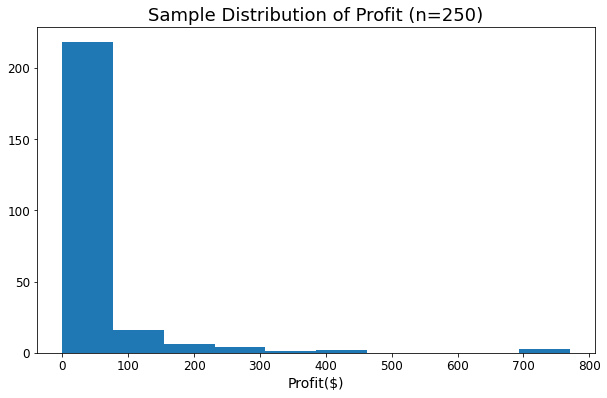

In [4]:
plot_hist(data=profits_sample, title='Sample Distribution of Profit (n=250)', label='Profit($)')

In [5]:
print('Sample mean profit: ', profits_sample.mean())

Sample mean profit:  42.547162799999995


In [8]:
bootstrap_samples = []
bootstrap_dist = []

for rs in range(10000):
    boot_samp = profits_sample.sample(n=250, replace=True, random_state=rs)
    bootstrap_samples.append(boot_samp)
    
    boot_mean = boot_samp.mean()
    bootstrap_dist.append(boot_mean)

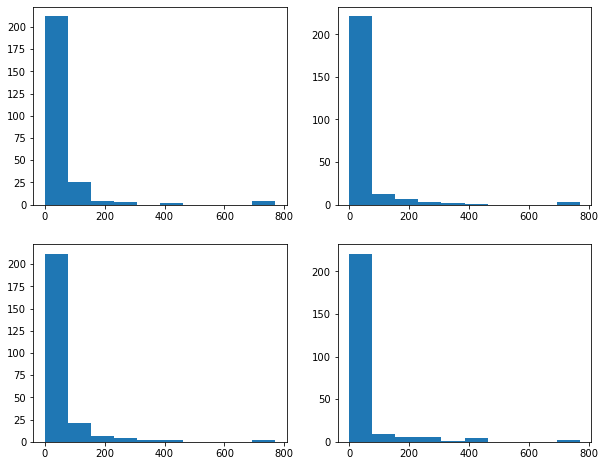

In [9]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10,8))
for i in range(2):
    for j in range(2):
        ax[i][j].hist(bootstrap_samples[i*2+j])

In [10]:
print('Mean of 10,000 bootstrap resamples: ', np.mean(bootstrap_dist))

Mean of 10,000 bootstrap resamples:  42.60927490768


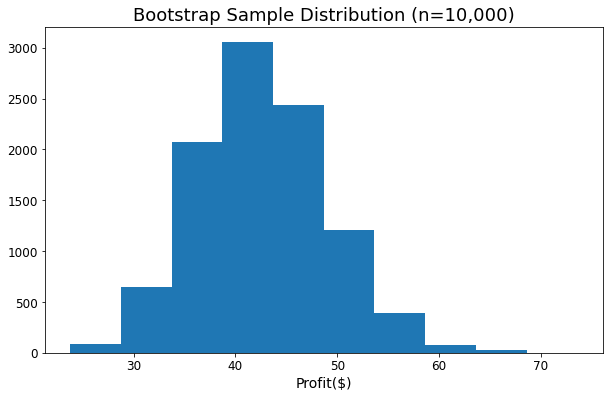

In [12]:
plot_hist(data=bootstrap_dist, title='Bootstrap Sample Distribution (n=10,000)', label='Profit($)')

Construct a 90% confidence interval

Cut off the top and bottom 5% of the data.

In [13]:
bootstrap_sorted = np.sort(bootstrap_dist)

In [14]:
lower_idx, upper_idx = int(len(bootstrap_dist) * .05), int(len(bootstrap_dist) * .95)

print('Lower index: ', lower_idx)
print('Upper index: ', upper_idx)

Lower index:  500
Upper index:  9500


In [15]:
lower_bound, upper_bound = bootstrap_sorted[lower_idx], bootstrap_sorted[upper_idx]

In [17]:
print('90% confidence interval of the bootstrap sampling distribution of mean profit: ', (lower_bound, upper_bound))

90% confidence interval of the bootstrap sampling distribution of mean profit:  (32.7387372, 53.590760800000005)


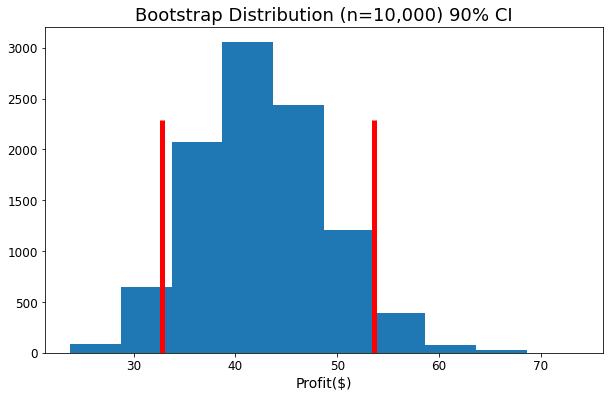

In [18]:
plot_hist(data=bootstrap_dist, title='Bootstrap Distribution (n=10,000) 90% CI',
        label='Profit($)', vlines=[lower_bound, upper_bound])

Explore population distribution

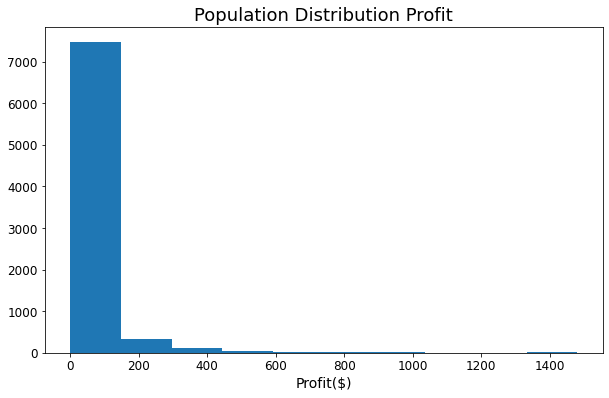

In [19]:
plot_hist(data=pop_profit, title='Population Distribution Profit', label='Profit($)')

In [20]:
print('Mean Profit of Population: ', pop_profit.mean())

Mean Profit of Population:  46.91932211993033


In [21]:
print('Original Sample Mean: ', profits_sample.mean())

Original Sample Mean:  42.547162799999995


## SMOTE

Synthetic Minority Over-sampling Technique is a strategy used to address a very common challenge in machine learning: class imbalance. Class imbalance refers to classification problems with one class in the dataset being more prevalent than others. 

Examples include:
- Fraud
- Medical scans
- Car crashes

A model trained on an imbalanced dataset will naturally be biased to predict the majority class. A common method to counteract this issue involves generating synthetic observations of the minority class. We can give the model more data to learn from without investing additional resources to collect real data!

The example below looks at a the [Telecom Churn](https://www.kaggle.com/datasets/mnassrib/telecom-churn-datasets?select=churn-bigml-80.csv) dataset. Our goal is to use information on customer behavior to predict whether or not the customer cancels their subscription (churn).

In [22]:
# Read churn csv into DataFrame
df = pd.read_csv('data/churn-bigml-80.csv')
df.head()

,State,Account length,Area code,International plan,Voice mail plan,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls,Churn
0,KS,128,415,No,Yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,No,Yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,No,No,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,408,Yes,No,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,415,Yes,No,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False


#### Tasks:
- Explore distribution of target variable
- Train model on original, imbalanced data
- Generate synthetic samples of minority class
- Train new model and compare results

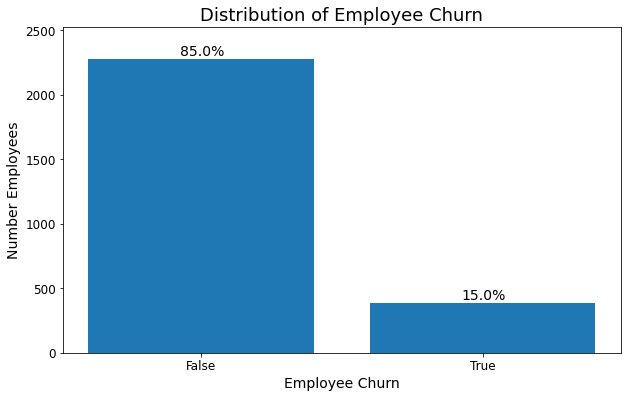

In [23]:
plot_churn(df)

In [24]:
# Separate features and target
X = df.select_dtypes(include='number').drop(columns='Area code')
y = df['Churn']

# Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42)

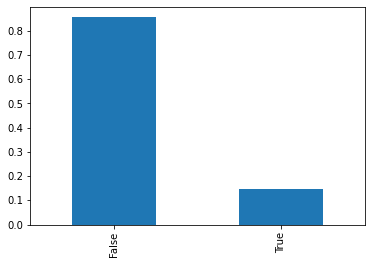

In [25]:
y_train.value_counts(normalize=True).plot.bar();

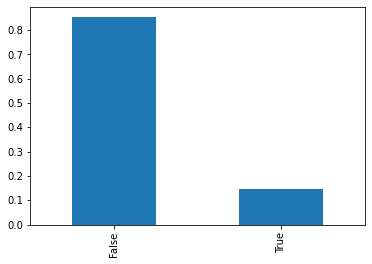

In [26]:
y_test.value_counts(normalize=True).plot.bar();

In [27]:
# Instantiate LogisticRegression
model1 = LogisticRegression(random_state=42, max_iter=500)

Training Accuracy:  0.8574108818011257
Testing Accuracy:  0.8595505617977528
-------------------
Training Precision:  0.5555555555555556
Testing Precision:  0.6428571428571429
-------------------
Training Recall:  0.08090614886731391
Testing Recall:  0.11392405063291139
-------------------


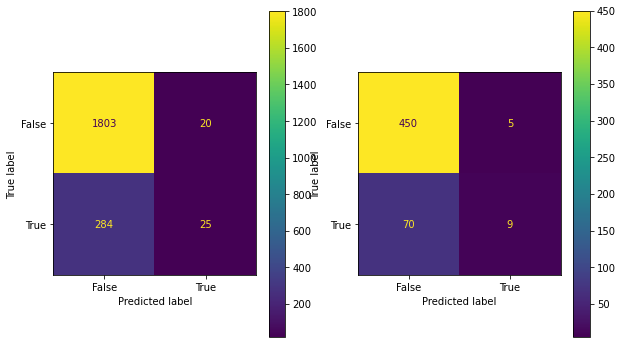

In [28]:
model_churn(model1, X_train, X_test, y_train, y_test)

In [29]:
# # Import SMOTE (Synthetic Minority Over-sampling Technique)
from imblearn.over_sampling import SMOTE

In [30]:
X_resampled, y_resampled = SMOTE(random_state=42).fit_resample(X_train, y_train)

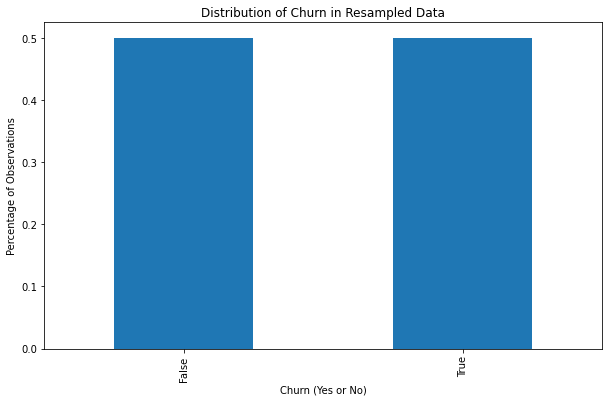

In [31]:
y_resampled.astype(str).value_counts(normalize=True).plot.bar(figsize=(10,6)).set(
    title='Distribution of Churn in Resampled Data',
    xlabel='Churn (Yes or No)',
    ylabel='Percentage of Observations'
);

In [32]:
model2 = LogisticRegression(random_state=42, max_iter=500)

Training Accuracy:  0.6889742183214481
Testing Accuracy:  0.6835205992509363
-------------------
Training Precision:  0.6845206213176218
Testing Precision:  0.27941176470588236
-------------------
Training Recall:  0.7010422380691168
Testing Recall:  0.7215189873417721
-------------------


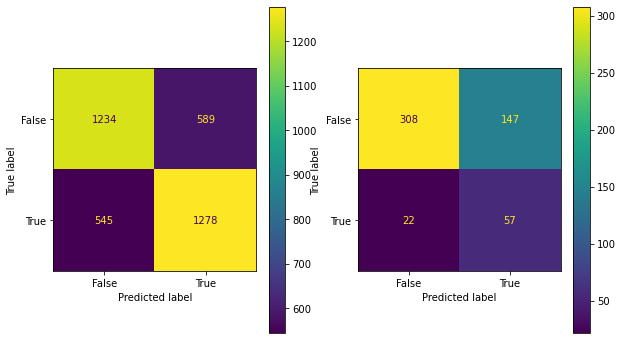

In [33]:
model_churn(model2, X_resampled, X_test, y_resampled, y_test)

In [34]:
from imblearn.over_sampling import ADASYN

In [35]:
X_resampled2, y_resampled2 = ADASYN(random_state=42).fit_resample(X_train, y_train)

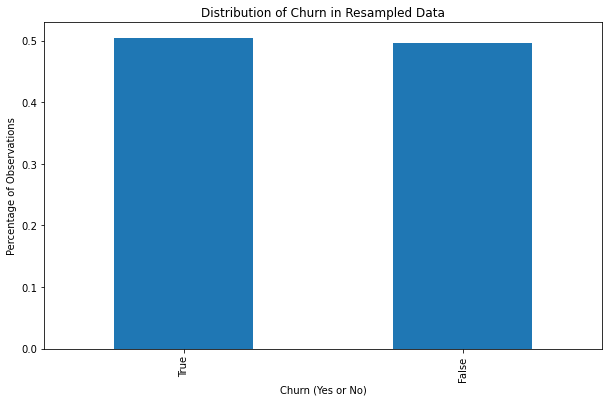

In [36]:
y_resampled2.astype(str).value_counts(normalize=True).plot.bar(figsize=(10,6)).set(
    title='Distribution of Churn in Resampled Data',
    xlabel='Churn (Yes or No)',
    ylabel='Percentage of Observations'
);

Training Accuracy:  0.6676638564046777
Testing Accuracy:  0.651685393258427
-------------------
Training Precision:  0.6645833333333333
Testing Precision:  0.2643171806167401
-------------------
Training Recall:  0.6882416396979504
Testing Recall:  0.759493670886076
-------------------


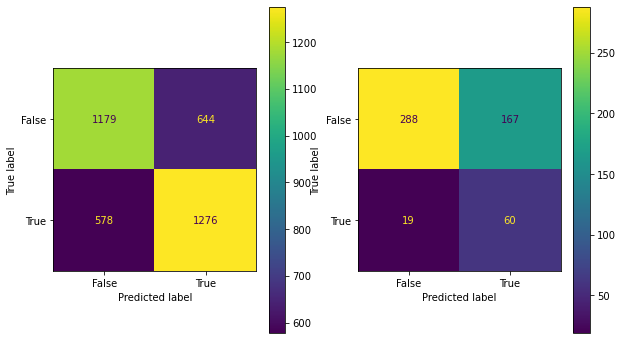

In [37]:
model_churn(model2, X_resampled2, X_test, y_resampled2, y_test)

## Image Augmentation

> "Data augmentation is a strategy that enables practitioners to significantly increase the diversity of data available for training models, without actually collecting new data." [Berkeley Artifical Intelligence Research](https://bair.berkeley.edu/blog/2019/06/07/data_aug/)

Let's look at a simple example with the MNIST dataset on images of hand-written digits. The following example is taken from this [article](https://machinelearningmastery.com/image-augmentation-deep-learning-keras/).

#### Tasks:
- Load MNIST data
- Explore basic images
- [Tensorflow Image Augmentation](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator) tool
- Create full dataset

In [38]:
# Import MNIST dataset
from tensorflow.keras.datasets import mnist

In [39]:
# Load Data
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# Standardize images and convert to float
X_train = X_train.reshape((X_train.shape[0], 28, 28, 1))
X_test = X_test.reshape((X_test.shape[0], 28, 28, 1))
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

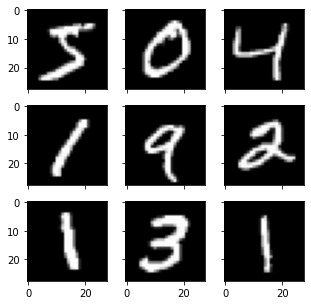

In [40]:
# Explore original data
plot_grid(X_train)

In [41]:
# Import Tensorflow Image Augmentation Tool
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [42]:
# Instantiate image augmentation object with zoom_range
datagen = ImageDataGenerator(zoom_range=.5)

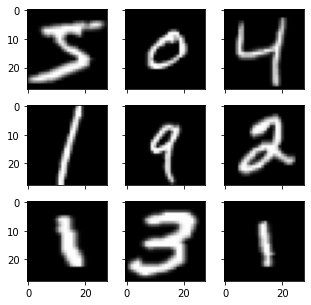

In [43]:
for X_batch, y_batch in datagen.flow(X_train, y_train, batch_size=9, shuffle=False):
    plot_grid(X_batch)
    break

In [46]:
datagen2 = ImageDataGenerator(zoom_range=.35, rotation_range=45, width_shift_range=.15,
                             height_shift_range=.15)

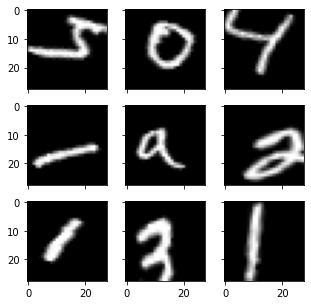

In [47]:
for X_batch, y_batch in datagen2.flow(X_train, y_train, batch_size=9, shuffle=False):
    plot_grid(X_batch)
    break

In [48]:
!mkdir aug_images

In [49]:
!ls

Generating_Synthetic_Data.pdf    data
README.md                        environment.yml
Untitled.ipynb                   images
Untitled1.ipynb                  src
aug_images                       workshop-notebook-session1.ipynb
aug_images2                      workshop-notebook.ipynb


In [50]:
image_gen = datagen2.flow(X_train, y_train, batch_size=1, shuffle=False,
                         save_to_dir='aug_images2', save_prefix='aug', save_format='jpg')

In [51]:
total = 1000
count = 0

for image in image_gen:
    count +=1
    
    if count == total:
        break

In [52]:
len(os.listdir('aug_images2'))

1000

## Synthetic Data Vault (SDV)

>"The **Synthetic Data Vault (SDV)** is a **Synthetic Data Generation** ecosystem of libraries that allows users to easily learn single-table, multi-table and timeseries datasets to later on generate new **Synthetic Data** that has the **same format and statistical properties** as the original dataset." [Synthetic Data Vault](https://sdv.dev/SDV/index.html)

Topics to Discuss:
- Fitting model and generating data
- Faker and anonymizing sensitive information
- Exploring distributions
- Constraints and creating your own
- Metrics to measure utility

In [53]:
# Import SDV packages
from sdv.demo import load_tabular_demo
from sdv.tabular import GaussianCopula

# Statistical Metrics
from sdv.evaluation import evaluate

# Distinguishability Metrics
from sdv.metrics.tabular import LogisticDetection

# Privacy Metric
from sdv.metrics.tabular import NumericalLR

In [54]:
data = load_tabular_demo('student_placements_pii')
data.head()

,student_id,address,gender,second_perc,high_perc,high_spec,degree_perc,degree_type,work_experience,experience_years,employability_perc,mba_spec,mba_perc,salary,placed,start_date,end_date,duration
0,17264,"70304 Baker Turnpike\nEricborough, MS 15086",M,67.00,91.00,Commerce,58.00,Sci&Tech,False,0,55.0,Mkt&HR,58.80,27000.0,True,2020-07-23,2020-10-12,3.0
1,17265,"805 Herrera Avenue Apt. 134\nMaryview, NJ 36510",M,79.33,78.33,Science,77.48,Sci&Tech,True,1,86.5,Mkt&Fin,66.28,20000.0,True,2020-01-11,2020-04-09,3.0
2,17266,"3702 Bradley Island\nNorth Victor, FL 12268",M,65.00,68.00,Arts,64.00,Comm&Mgmt,False,0,75.0,Mkt&Fin,57.80,25000.0,True,2020-01-26,2020-07-13,6.0
3,17267,Unit 0879 Box 3878\nDPO AP 42663,M,56.00,52.00,Science,52.00,Sci&Tech,False,0,66.0,Mkt&HR,59.43,NaN,False,NaT,NaT,NaN
4,17268,"96493 Kelly Canyon Apt. 145\nEast Steven, NC 3...",M,85.80,73.60,Commerce,73.30,Comm&Mgmt,False,0,96.8,Mkt&Fin,55.50,42500.0,True,2020-07-04,2020-09-27,3.0


In [55]:
len(data)

215

In [60]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 215 entries, 0 to 214
Data columns (total 18 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   student_id          215 non-null    int64         
 1   address             215 non-null    object        
 2   gender              215 non-null    object        
 3   second_perc         215 non-null    float64       
 4   high_perc           215 non-null    float64       
 5   high_spec           215 non-null    object        
 6   degree_perc         215 non-null    float64       
 7   degree_type         215 non-null    object        
 8   work_experience     215 non-null    bool          
 9   experience_years    215 non-null    int64         
 10  employability_perc  215 non-null    float64       
 11  mba_spec            215 non-null    object        
 12  mba_perc            215 non-null    float64       
 13  salary              148 non-null    float64       

In [64]:
model1 = GaussianCopula(primary_key='student_id')

In [65]:
model1.fit(data)

In [72]:
new_data1 = model1.sample(len(data))

In [73]:
new_data1.head()

,student_id,address,gender,second_perc,high_perc,high_spec,degree_perc,degree_type,work_experience,experience_years,employability_perc,mba_spec,mba_perc,salary,placed,start_date,end_date,duration
0,0,"42261 Booth Shores\nNorth Pattyfurt, UT 01028",M,74.37,56.95,Commerce,70.82,Comm&Mgmt,False,0,86.44,Mkt&HR,54.71,20021.0,True,2020-02-23 19:08:13.053103616,2020-10-03 17:48:11.425407232,8.0
1,1,"PSC 2246, Box 1611\nAPO AE 85767",M,68.35,62.60,Commerce,59.84,Sci&Tech,False,0,73.54,Mkt&HR,59.94,29983.0,True,2020-02-05 10:53:28.760486400,2020-04-28 16:19:26.677188608,3.0
2,2,"51656 Emily Knolls\nNorth Alyssabury, NV 19983",M,55.40,64.69,Science,65.99,Comm&Mgmt,True,2,69.79,Mkt&Fin,52.76,22750.0,True,2020-02-26 22:23:24.987390208,2020-10-16 15:10:20.260036608,7.0
3,3,"82602 Wilcox Curve\nNew Angela, OR 84462",M,74.27,66.21,Commerce,68.09,Comm&Mgmt,False,0,61.68,Mkt&Fin,67.42,26328.0,True,2020-01-25 17:49:46.902769920,2020-11-10 02:28:32.441205760,10.0
4,4,"6175 Eugene Crossing\nCurryview, OH 86092",M,57.73,76.02,Science,68.36,Comm&Mgmt,True,1,57.58,Mkt&Fin,54.19,30061.0,True,2020-04-18 14:22:16.572822528,2020-06-25 01:02:21.442343424,4.0


In [69]:
new_data1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 215 entries, 0 to 214
Data columns (total 18 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   student_id          215 non-null    int64         
 1   address             215 non-null    object        
 2   gender              215 non-null    object        
 3   second_perc         215 non-null    float64       
 4   high_perc           215 non-null    float64       
 5   high_spec           215 non-null    object        
 6   degree_perc         215 non-null    float64       
 7   degree_type         215 non-null    object        
 8   work_experience     215 non-null    bool          
 9   experience_years    215 non-null    int64         
 10  employability_perc  215 non-null    float64       
 11  mba_spec            215 non-null    object        
 12  mba_perc            215 non-null    float64       
 13  salary              122 non-null    float64       

In [70]:
data['student_id'].nunique()

215

In [71]:
new_data1['student_id'].nunique()

215

How many synthetic addresses are from original dataset?

In [77]:
len(set(data['address']).intersection(set(new_data1['address'])))

136

Explore Faker package

In [79]:
from faker import Faker

In [80]:
fake = Faker()

In [84]:
fake.address()

'8078 Anderson Club Apt. 216\nNorth Jamieside, IA 37326'

Include fields to anonymize in SDV model

In [85]:
model2 = GaussianCopula(primary_key='student_id', anonymize_fields={'address': 'address'})

In [86]:
model2.fit(data)

In [87]:
new_data2 = model2.sample(len(data))

In [88]:
new_data2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 215 entries, 0 to 214
Data columns (total 18 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   student_id          215 non-null    int64         
 1   address             215 non-null    object        
 2   gender              215 non-null    object        
 3   second_perc         215 non-null    float64       
 4   high_perc           215 non-null    float64       
 5   high_spec           215 non-null    object        
 6   degree_perc         215 non-null    float64       
 7   degree_type         215 non-null    object        
 8   work_experience     215 non-null    bool          
 9   experience_years    215 non-null    int64         
 10  employability_perc  215 non-null    float64       
 11  mba_spec            215 non-null    object        
 12  mba_perc            215 non-null    float64       
 13  salary              124 non-null    float64       

In [90]:
new_data2['student_id'].nunique()

215

In [91]:
len(set(data['address']).intersection(set(new_data2['address'])))

0

#### Statistical Metrics

Are the distributions of the synthetic data statistically different than the underlying distributions from original data?

SDV uses two statistical tests to compare distributions.

##### Kolmogorov-Smirnov Test (KS Test)
Compare two continuous distributions.

- Null Hypothesis: No difference between the two distributions
- Alternative Hypothesis: The two distributions are statistically different


##### Chi-Squared Goodness of Fit Test
Compare two discrete/categorical distributions.

- Null Hypothesis: No difference between the two distributions
- Alternative Hypothesis: The two distributions are statistically different

In [93]:
new_data2.dtypes

student_id                     int64
address                       object
gender                        object
second_perc                  float64
high_perc                    float64
high_spec                     object
degree_perc                  float64
degree_type                   object
work_experience                 bool
experience_years               int64
employability_perc           float64
mba_spec                      object
mba_perc                     float64
salary                       float64
placed                          bool
start_date            datetime64[ns]
end_date              datetime64[ns]
duration                     float64
dtype: object

In [92]:
evaluate(new_data2, data, aggregate=False)

,metric,name,raw_score,normalized_score,min_value,max_value,goal,error
0,KSComplement,Inverted Kolmogorov-Smirnov D statistic,0.758563,0.758563,0.0,1.0,MAXIMIZE,None
1,CSTest,Chi-Squared,0.781631,0.781631,0.0,1.0,MAXIMIZE,None


In [94]:
evaluate(new_data2, data)

0.7700970527305153

Explore modeled distributions

In [95]:
model2.get_distributions()

{'address.value': 'copulas.univariate.truncated_gaussian.TruncatedGaussian',
 'gender.value': 'copulas.univariate.truncated_gaussian.TruncatedGaussian',
 'second_perc.value': 'copulas.univariate.truncated_gaussian.TruncatedGaussian',
 'high_perc.value': 'copulas.univariate.truncated_gaussian.TruncatedGaussian',
 'high_spec.value': 'copulas.univariate.truncated_gaussian.TruncatedGaussian',
 'degree_perc.value': 'copulas.univariate.truncated_gaussian.TruncatedGaussian',
 'degree_type.value': 'copulas.univariate.truncated_gaussian.TruncatedGaussian',
 'work_experience.value': 'copulas.univariate.truncated_gaussian.TruncatedGaussian',
 'experience_years.value': 'copulas.univariate.truncated_gaussian.TruncatedGaussian',
 'employability_perc.value': 'copulas.univariate.truncated_gaussian.TruncatedGaussian',
 'mba_spec.value': 'copulas.univariate.truncated_gaussian.TruncatedGaussian',
 'mba_perc.value': 'copulas.univariate.truncated_gaussian.TruncatedGaussian',
 'salary.value': 'copulas.univa

In [99]:
mask1 = (data['work_experience'] == False) & (data['experience_years'] > 0)
mask2 = (data['work_experience'] == True) & (data['experience_years'] == 0)

In [101]:
data[mask2]

,student_id,address,gender,second_perc,high_perc,high_spec,degree_perc,degree_type,work_experience,experience_years,employability_perc,mba_spec,mba_perc,salary,placed,start_date,end_date,duration


In [102]:
mask3 = (new_data2['work_experience'] == False) & (new_data2['experience_years'] > 0)
mask4 = (new_data2['work_experience'] == True) & (new_data2['experience_years'] == 0)

In [106]:
new_data2[mask4]

,student_id,address,gender,second_perc,high_perc,high_spec,degree_perc,degree_type,work_experience,experience_years,employability_perc,mba_spec,mba_perc,salary,placed,start_date,end_date,duration
52,52,"5566 Holly Valley Suite 609\nThomasport, NC 12929",M,68.40,59.54,Science,73.66,Comm&Mgmt,True,0,77.72,Mkt&Fin,64.12,37639.0,True,2020-05-12 23:27:46.063097344,2020-05-08 22:42:05.161846016,3.0
201,201,"857 Mario Centers Suite 192\nYolandamouth, ND ...",M,77.71,80.68,Commerce,73.96,Comm&Mgmt,True,0,81.97,Mkt&Fin,63.73,36076.0,True,2020-05-12 05:20:47.134124288,2020-10-04 00:12:37.185780480,4.0


In [108]:
LogisticDetection().compute(data.drop(columns='address'), new_data2.drop(columns='address'))

0.0